# Brain Tumor Detection Using Deep Learning (MRI Images)

Misdiagnoses can change lives. In a world where early intervention can mean the difference between life and death, I believe technology has a responsibility: to support, to guide, and when possible, to save.

This project is my attempt to explore that intersection between humanity and innovation.

Using deep learning, I built a system that classifies brain MRI scans into **tumor** or **non-tumor** categories. It's not a replacement for doctors, but it could be a powerful assistant. Whether it's helping reduce diagnostic errors, speeding up radiology workflows, or supporting screening efforts in under-resourced areas, the possibilities are meaningful.

This notebook walks through the entire pipeline, from raw images to a working prototype powered by Python and modern AI tools :)

---

## Reason I chose this project:

I chose this project because the stakes are real. Brain tumors are notoriously difficult to detect early, and delays in diagnosis can be catastrophic. I wanted to see how far I could push a machine learning model to assist in this critical space.

---

## Technical Overview

- **Objective**: Automatically detect brain tumors from MRI scans
- **Dataset**: [Brain MRI Dataset (Kaggle)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- **Approach**: Transfer learning using pre-trained CNNs (like VGG16, ResNet50)
- **Tools Used**: Python, TensorFlow/Keras, OpenCV for preprocessing, and Google Colab for training and experimentation. Deployment Goal: A lightweight web interface (planned via HTML/CSS and JS or Flask) that enables users to upload MRI scans and receive real-time tumor predictions.
- **End Product**: A simple web app where users can upload an MRI scan and get a prediction result

---

## Workflow Overview

1. **Load and organize** the MRI image data
2. **Visualize** sample scans to understand patterns and variations
3. **Preprocess** the data — resize, normalize, and augment the images
4. **Build and fine-tune** a CNN model using transfer learning
5. **Evaluate** model performance using metrics like accuracy, confusion matrix, and classification report
6. **Deploy** the model in a user-friendly Flask app with a basic HTML interface

---

>  *Disclaimer: This is a research and learning prototype — not a medical diagnostic tool. Always consult a healthcare professional for clinical decisions.*

---

Thank you for being here. I hope this project not only helps me grow as a developer, but also opens up conversations about how tech can support real human needs — especially in something as serious as healthcare.

Let’s get started!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and Tools


In [2]:
import os  # For handling file paths and directories
import numpy as np  # For numerical operations and arrays
import random  # For random number generation (e.g., shuffling data)
from PIL import Image, ImageEnhance  # For image loading and enhancement (e.g., brightness, contrast)

# Keras (Deep Learning framework built into TensorFlow)
from tensorflow.keras.models import Sequential  # For building a linear stack of layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout  # Common layers used in neural networks
from tensorflow.keras.preprocessing.image import load_img  # For loading image files as PIL images
from tensorflow.keras.optimizers import Adam  # Optimizer used for training the model
from tensorflow.keras.applications import VGG16  # Pretrained CNN model (Transfer Learning)
from sklearn.utils import shuffle  # Utility to randomly shuffle data arrays

## Load Datasets


In [3]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI images/Training'
test_dir = '/content/drive/MyDrive/MRI images/Testing'

# Load and shuffle the training data
train_paths = []
train_labels = []

# Loop through each class folder
for label in os.listdir(train_dir):
    class_path = os.path.join(train_dir, label)

    # Handle one extra nested folder if it exists
    inner_dirs = os.listdir(class_path)
    if len(inner_dirs) == 1 and os.path.isdir(os.path.join(class_path, inner_dirs[0])):
        class_path = os.path.join(class_path, inner_dirs[0])  # go one level deeper

    for image in os.listdir(class_path):
        train_paths.append(os.path.join(class_path, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    class_path = os.path.join(test_dir, label)

    # Handle one extra nested folder if it exists
    inner_dirs = os.listdir(class_path)
    if len(inner_dirs) == 1 and os.path.isdir(os.path.join(class_path, inner_dirs[0])):
        class_path = os.path.join(class_path, inner_dirs[0])  # go one level deeper

    for image in os.listdir(class_path):
        test_paths.append(os.path.join(class_path, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


##Data Visualization


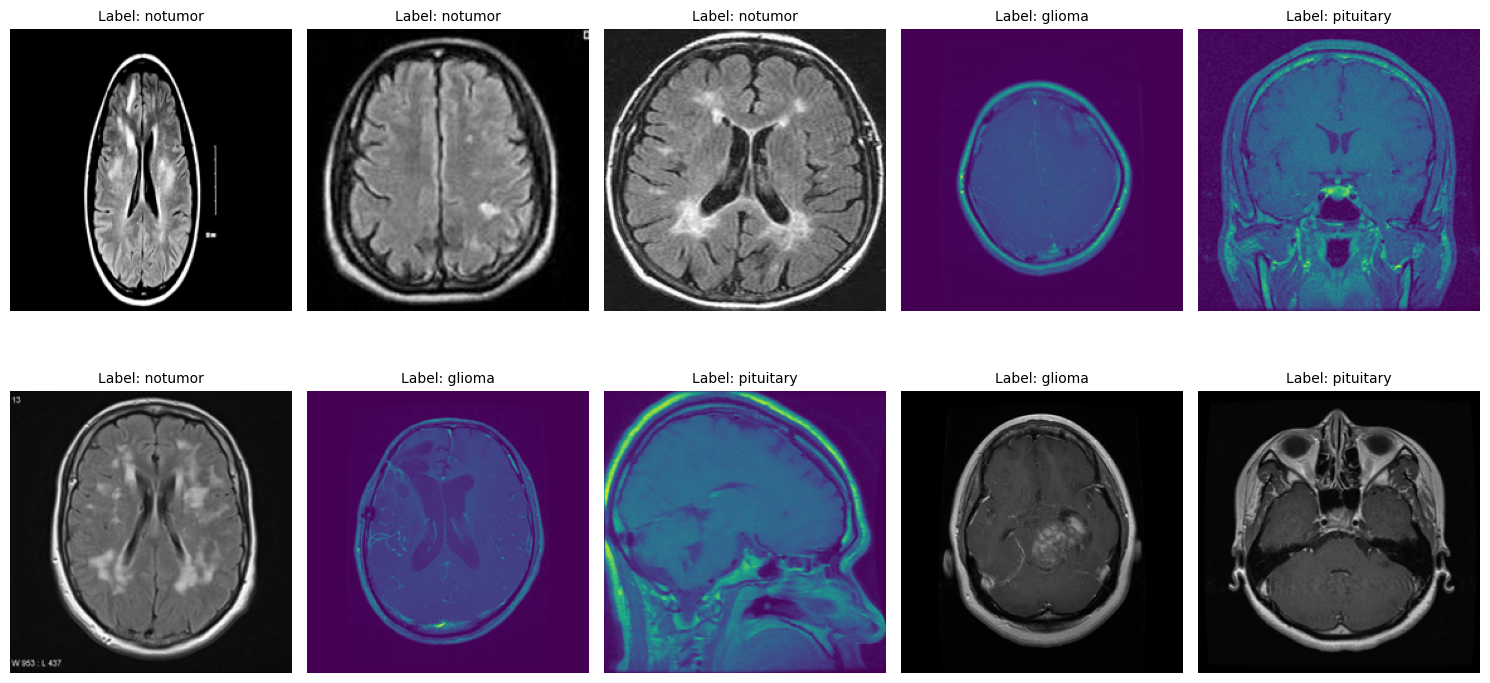

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

##Image Preprocessing (Helper Function)

In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

## Model Overview: Transfer Learning with VGG16

We are using **VGG16** for transfer learning. The model is built on top of VGG16, a pre-trained convolutional neural network (CNN) widely used for image classification.

### Model Construction Steps:

- **Load the VGG16 base model**:
  - `input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)` — matches our image dimensions (128x128).
  - `include_top=False` — excludes VGG16’s original classification layers.
  - `weights='imagenet'` — loads pre-trained weights from the ImageNet dataset (1.4M+ images).

- **Freeze all base layers**:
  - Loop through `base_model.layers` and set each to `trainable = False` to prevent their weights from being updated during training.

- **Unfreeze the last three layers**:
  - Set `trainable = True` for `base_model.layers[-2]`, `[-3]`, and `[-4]` to allow fine-tuning on our dataset.

- **Create the final model using `Sequential()`**:
  - Add the modified VGG16 base model with `model.add(base_model)`.

- **Add a `Flatten` layer**:
  - `model.add(Flatten())` — reshapes the 3D output from VGG16 to 1D for the dense layers.

- **Add a `Dropout` layer**:
  - `model.add(Dropout(0.3))` — helps prevent overfitting by randomly deactivating neurons during training.

- **Add a fully connected `Dense` layer**:
  - `model.add(Dense(128, activation='relu'))` — introduces learnable features after flattening.

- **Add another `Dropout` layer**:
  - `model.add(Dropout(0.2))` — provides additional regularization.

- **Add the final output layer**:
  - `model.add(Dense(len(unique_labels), activation='softmax'))` — outputs class probabilities for each category using the softmax function.

---

This architecture combines the powerful feature extraction of VGG16 with a lightweight custom classification head tailored to our tumor detection task.


In [6]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1238s 5s/step - loss: 0.5273 - sparse_categorical_accuracy: 0.8085
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1234s 5s/step - loss: 0.2040 - sparse_categorical_accuracy: 0.9286
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1207s 5s/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9561
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1198s 5s/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9707
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1195s 5s/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9738


##Train and Val Plots

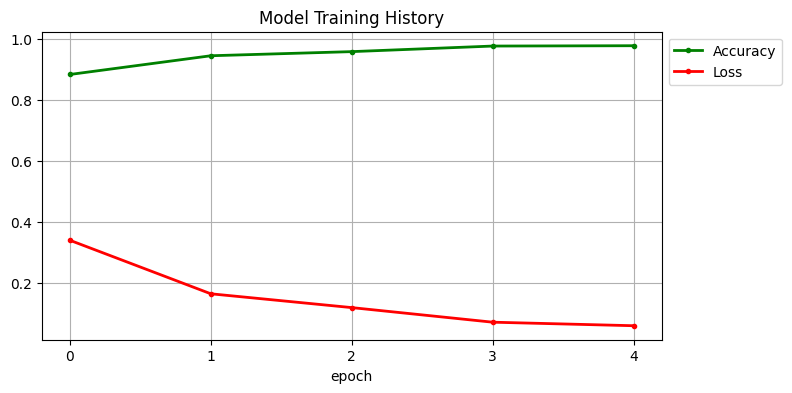

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

##Model Classification Report

In [8]:
import matplotlib.pyplot as plt  # This helps us draw pictures like graphs and charts
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # These are tools to tell us how smart our model is (how well it did)
import seaborn as sns  # This is a coloring book for charts—it makes them look nicer!
from sklearn.preprocessing import label_binarize  # This helps us turn words into numbers (so the computer can understand them)
from tensorflow.keras.models import load_model  # Lets us bring in a model that we saved before
import numpy as np  # This helps us with numbers and math—like a calculator for arrays

# Load test data
test_images = open_images(test_paths)
# This line says: “Get all the pictures we want to test and get them ready!”

# Encode the true labels
test_labels_encoded = encode_label(test_labels)
# Here, we’re turning the real answers (like "yes" or "no") into numbers,
# so the computer can compare its guesses with the truth.

# Make predictions
test_predictions = model.predict(test_images)
# Now we ask our smart model to look at each picture and guess if it shows a tumor or not.

# Generate classification report
print("Classification Report: ")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))
# This prints a report card for the model.
# It tells us how many times the model was right or wrong,
# and how good it was at recognizing each type of image (like "tumor" or "no tumor").


41/41 ━━━━━━━━━━━━━━━━━━━━ 280s 7s/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       300
           1       0.96      0.39      0.55       306
           2       0.89      1.00      0.94       405
           3       0.86      0.99      0.92       300

    accuracy                           0.85      1311
   macro avg       0.86      0.83      0.81      1311
weighted avg       0.87      0.85      0.82      1311



##Model Confusion Matrix and Plot


In [ ]:
import matplotlib.pyplot as plt  # This helps us draw pictures like graphs and charts
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # These are tools to tell us how smart our model is (how well it did)
import seaborn as sns  # This is a coloring book for charts—it makes them look nicer!
from sklearn.preprocessing import label_binarize  # This helps us turn words into numbers (so the computer can understand them)
from tensorflow.keras.models import load_model  # Lets us bring in a model that we saved before
import numpy as np  # This helps us with numbers and math—like a calculator for arrays


# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##Roc Curve Plot

In [ ]:
import matplotlib.pyplot as plt  # This helps us draw pictures like graphs and charts
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # These are tools to tell us how smart our model is (how well it did)
import seaborn as sns  # This is a coloring book for charts—it makes them look nicer!
from sklearn.preprocessing import label_binarize  # This helps us turn words into numbers (so the computer can understand them)
from tensorflow.keras.models import load_model  # Lets us bring in a model that we saved before
import numpy as np  # This helps us with numbers and math—like a calculator for arrays

# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

##Save and load model


In [11]:
# Save the entire model
model.save('model.h5')

In [12]:
##loading the model
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')


##MRI Tumor Detection System


In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


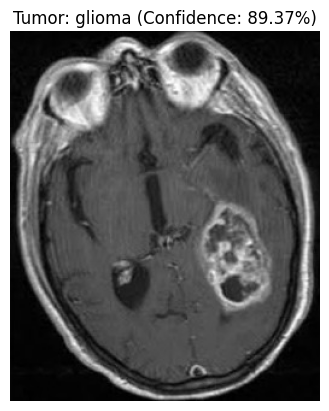

In [14]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


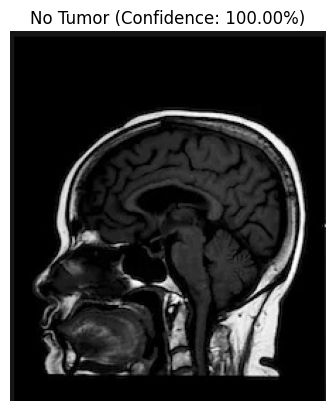

In [15]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


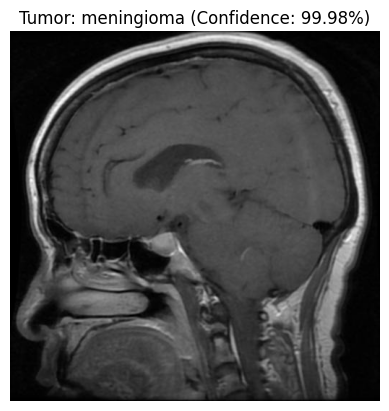

In [16]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


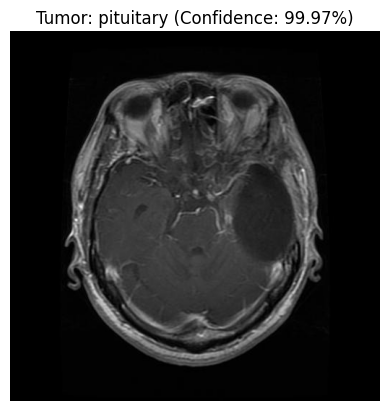

In [18]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)